# Import libraries

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize


# Dataset

### Generate stock data for 10 stocks for past 20 years

### Selecting Top 10 S&P 500 companies by market cap

In [ ]:
import pandas as pd
import yfinance as yf

# Fetch the S&P 500 company data
def get_sp500_companies():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    sp500_table = pd.read_html(url)
    sp500_data = sp500_table[0][['Symbol', 'Security']]
    return sp500_data

# Get market cap for each company
def get_top_companies_by_market_cap(n=10):
    sp500_companies = get_sp500_companies()
    market_caps = []

    # Loop through tickers and fetch market cap
    for ticker in sp500_companies['Symbol']:
        try:
            stock = yf.Ticker(ticker)
            market_cap = stock.info.get('marketCap', 0)
            market_caps.append((ticker, stock.info['longName'], market_cap))
        except:
            continue

    # Create a DataFrame with market cap data
    market_cap_df = pd.DataFrame(market_caps, columns=['Ticker', 'Company', 'Market Cap'])
    market_cap_df = market_cap_df.sort_values(by='Market Cap', ascending=False).head(n)

    return market_cap_df

# Fetch top 10 companies by market cap
top_companies = get_top_companies_by_market_cap(10)
print("Top 10 Companies by Market Cap in the S&P 500:")
print(top_companies)



Top 10 Companies by Market Cap in the S&P 500:
    Ticker                Company     Market Cap
39    AAPL             Apple Inc.  3820479053824
316   MSFT  Microsoft Corporation  3375918743552
346   NVDA     NVIDIA Corporation  3158230695936
22    AMZN       Amazon.com, Inc.  2427913502720
20    GOOG          Alphabet Inc.  2402749251584
19   GOOGL          Alphabet Inc.  2400751190016
310   META   Meta Platforms, Inc.  1562002849792
441   TSLA            Tesla, Inc.  1533228613632
71    AVGO          Broadcom Inc.  1112713461760
481    WMT           Walmart Inc.   763654045696


In [ ]:
top_companies['Ticker']

,Ticker
39,AAPL
316,MSFT
346,NVDA
22,AMZN
20,GOOG
19,GOOGL
310,META
441,TSLA
71,AVGO
481,WMT


### Fetch data for the choosen 10 companies (20 years of data with 10 parameters )

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the tickers for the top 10 companies
# tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'TSLA', 'NVDA', 'BRK-B', 'META', 'V', 'JPM']
tickers = top_companies['Ticker'].tolist()

# Function to calculate additional parameters
def calculate_parameters(data):
    if 'Close' not in data.columns:
        data['Close'] = data['Close']

    # Ensure tz-naive DatetimeIndex
    data.index = data.index.tz_localize(None)

    # Daily Returns
    data['Daily Return'] = data['Close'].pct_change() * 100

    # Volatility (Rolling 30 days)
    data['Volatility'] = data['Daily Return'].rolling(window=30).std()

    # Moving Averages
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    data['MA_50'] = data['Close'].rolling(window=50).mean()

    # Relative Strength Index (RSI)
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-10)
    data['RSI'] = 100 - (100 / (1 + rs))

    # Sharpe Ratio (Rolling)
    data['Sharpe Ratio'] = (data['Daily Return'].rolling(window=30).mean() - 2) / data['Daily Return'].rolling(window=30).std()

    # Beta (Market Benchmark: SPY)
    market_data = yf.download('SPY', start=data.index.min(), end=data.index.max())['Close']
    market_data.index = market_data.index.tz_localize(None)  # Ensure tz-naive
    market_return = market_data.pct_change()
    covariance = data['Daily Return'].rolling(30).cov(market_return)
    market_variance = market_return.rolling(30).var()
    data['Beta'] = covariance / (market_variance + 1e-10)

    # Maximum Drawdown
    rolling_max = data['Close'].cummax()
    data['Max Drawdown'] = (data['Close'] - rolling_max) / rolling_max

    # Dividend Yield
    data['Dividend Yield'] = (data['Dividends'] / data['Close']) * 100

    return data

# Function to fetch data for all tickers
def fetch_stock_data(tickers, start_date, end_date, max_rows=2500000):
    all_data = []
    rows_per_ticker = max_rows // len(tickers)  # Distribute rows equally among tickers

    for ticker in tickers:
        print(f"Fetching data for: {ticker}")
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date, interval='1d')

        if data.empty:
            print(f"No data for {ticker}")
            continue

        # Limit rows to maintain total row count
        data = data.head(rows_per_ticker)
        data = calculate_parameters(data)

        # Keep only relevant columns
        data = data[['Close', 'Daily Return', 'Volatility', 'MA_10', 'MA_50',
                     'RSI', 'Sharpe Ratio', 'Beta', 'Dividend Yield', 'Max Drawdown']]

        data['Ticker'] = ticker
        all_data.append(data)

    # Combine all tickers into a single DataFrame
    final_data = pd.concat(all_data)
    print(f"Total rows fetched: {len(final_data)}")
    return final_data

# Parameters
start_date = "2005-01-01"
end_date = "2024-12-01"

# Fetch and display the data
portfolio_data = fetch_stock_data(tickers, start_date, end_date)
print(portfolio_data.head())

# Save to CSV (optional)
portfolio_data.to_csv("portfolio_data.csv", index=True)


Fetching data for: AAPL


[*********************100%***********************]  1 of 1 completed


Fetching data for: MSFT


[*********************100%***********************]  1 of 1 completed


Fetching data for: AMZN


[*********************100%***********************]  1 of 1 completed


Fetching data for: GOOG


[*********************100%***********************]  1 of 1 completed


Fetching data for: TSLA


[*********************100%***********************]  1 of 1 completed


Fetching data for: NVDA


[*********************100%***********************]  1 of 1 completed


Fetching data for: BRK-B


[*********************100%***********************]  1 of 1 completed


Fetching data for: META


[*********************100%***********************]  1 of 1 completed


Fetching data for: V


[*********************100%***********************]  1 of 1 completed


Fetching data for: JPM


[*********************100%***********************]  1 of 1 completed


Total rows fetched: 46074
               Close  Daily Return  Volatility  MA_10  MA_50  RSI  \
Date                                                                
2005-01-03  0.953359           NaN         NaN    NaN    NaN  NaN   
2005-01-04  0.963150      1.026989         NaN    NaN    NaN  NaN   
2005-01-05  0.971586      0.875798         NaN    NaN    NaN  NaN   
2005-01-06  0.972339      0.077556         NaN    NaN    NaN  NaN   
2005-01-07  1.043136      7.281135         NaN    NaN    NaN  NaN   

            Sharpe Ratio  Beta  Dividend Yield  Max Drawdown Ticker  
Date                                                                 
2005-01-03           NaN   NaN             0.0           0.0   AAPL  
2005-01-04           NaN   NaN             0.0           0.0   AAPL  
2005-01-05           NaN   NaN             0.0           0.0   AAPL  
2005-01-06           NaN   NaN             0.0           0.0   AAPL  
2005-01-07           NaN   NaN             0.0           0.0   AAPL  


In [ ]:
portfolio_data.shape

(46074, 11)

In [ ]:
portfolio_data.isna().sum()

,0
Close,0
Daily Return,10
Volatility,300
MA_10,90
MA_50,490
RSI,130
Sharpe Ratio,300
Beta,310
Dividend Yield,0
Max Drawdown,0


# Data Pre processing

### Fill null values

In [ ]:
# filling null values for Daily return
portfolio_data['Daily Return'] = portfolio_data['Daily Return'].fillna(0)

# filling null values for volatility
portfolio_data['Volatility'] = portfolio_data['Volatility'].ffill().bfill()

# filling null values for MA_10
portfolio_data['MA_10'] = portfolio_data['MA_10'].ffill().bfill()

# filling null values for MA_50
portfolio_data['MA_50'] = portfolio_data['MA_50'].ffill().bfill()

# filling null values for RSI
def calculate_rsi(data, window=14):
    delta = portfolio_data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / (loss + 1e-10)  # Avoid division by zero
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Recalculate RSI
portfolio_data['RSI'] = calculate_rsi(portfolio_data)
portfolio_data = portfolio_data.dropna(subset=['RSI']) # drop the values which cannot be calculated using the above method


# filling null values for Sharpe Ratio

# Function to calculate Sharpe Ratio
def calculate_sharpe_ratio(data, window=30, risk_free_rate=2):
    # Ensure no nulls in Daily Returns
    data['Daily Return'] = data['Daily Return'].fillna(0)

    # Rolling average return and rolling standard deviation (volatility)
    rolling_mean = data['Daily Return'].rolling(window=window).mean()
    rolling_std = data['Daily Return'].rolling(window=window).std()

    # Avoid division by zero and calculate Sharpe Ratio
    sharpe_ratio = (rolling_mean - risk_free_rate) / (rolling_std + 1e-10)  # Small epsilon to avoid zero division

    # Replace invalid values (e.g., inf, -inf, NaN) with 0
    sharpe_ratio = sharpe_ratio.replace([np.inf, -np.inf], 0).fillna(0)

    return sharpe_ratio

# Recalculate Sharpe Ratio
portfolio_data['Sharpe Ratio'] = calculate_sharpe_ratio(portfolio_data)


# filling null values for Beta
portfolio_data['Beta'] = portfolio_data['Beta'].ffill().bfill()
portfolio_data['Beta'].isnull().sum()

<ipython-input-7-480c963f7e7d>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Daily Return'] = data['Daily Return'].fillna(0)
<ipython-input-7-480c963f7e7d>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_data['Sharpe Ratio'] = calculate_sharpe_ratio(portfolio_data)
<ipython-input-7-480c963f7e7d>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

0

In [ ]:
portfolio_data.isna().sum()

,0
Close,0
Daily Return,0
Volatility,0
MA_10,0
MA_50,0
RSI,0
Sharpe Ratio,0
Beta,0
Dividend Yield,0
Max Drawdown,0


### Check spread of the data and normalize

In [ ]:
print(portfolio_data.describe())


              Close  Daily Return    Volatility         MA_10         MA_50  \
count  46061.000000  46061.000000  46061.000000  46061.000000  46061.000000   
mean      81.969084      0.111354      1.986953     82.207683     83.204404   
std       94.526863      2.308236      1.176139     94.783210     95.817864   
min        0.135270    -30.726573      0.380428      0.155950      0.172761   
25%       14.779915     -0.863669      1.177867     14.802431     14.865254   
50%       40.985435      0.072406      1.665906     41.125150     41.846227   
75%      129.303375      1.079848      2.440056    129.874001    131.370043   
max      595.459717     29.806721      9.574881    586.941559    574.588124   

                RSI  Sharpe Ratio          Beta  Dividend Yield  Max Drawdown  
count  46061.000000  46061.000000  46061.000000    46061.000000  46061.000000  
mean      54.250168     -1.253653    120.887538        0.003380     -0.148710  
std       16.909797      0.676862     60.747890 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_scale = ['Close','Daily Return', 'Volatility', 'MA_10', 'MA_50', 'RSI', 'Beta', 'Sharpe Ratio']
portfolio_data[columns_to_scale] = scaler.fit_transform(portfolio_data[columns_to_scale])


In [ ]:
print(portfolio_data.describe())


              Close  Daily Return    Volatility         MA_10         MA_50  \
count  46061.000000  46061.000000  46061.000000  46061.000000  46061.000000   
mean       0.137461      0.509437      0.174728      0.139833      0.144550   
std        0.158782      0.038132      0.127918      0.161530      0.166809   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.024599      0.493330      0.086731      0.024961      0.025578   
50%        0.068618      0.508794      0.139810      0.069820      0.072549   
75%        0.216971      0.525437      0.224008      0.221065      0.228401   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                RSI  Sharpe Ratio          Beta  Dividend Yield  Max Drawdown  
count  46061.000000  46061.000000  46061.000000    46061.000000  46061.000000  
mean       0.542492      0.734050      0.356037        0.003380     -0.148710  
std        0.169102      0.123052      0.068455 

### Additional columns for better training

In [ ]:
portfolio_data['Log Return'] = np.log(portfolio_data['Close'] / portfolio_data['Close'].shift(1)).fillna(0)


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
portfolio_data['Cumulative Return'] = (1 + portfolio_data['Daily Return'] / 100).cumprod()


In [ ]:
portfolio_data.columns

Index(['Close', 'Daily Return', 'Volatility', 'MA_10', 'MA_50', 'RSI',
       'Sharpe Ratio', 'Beta', 'Dividend Yield', 'Max Drawdown', 'Ticker',
       'Log Return', 'Cumulative Return'],
      dtype='object')

### Split into train and test set

In [ ]:
# Step 1: Ensure the 'Date' is the index
data = portfolio_data.reset_index()  # Reset index if Date is not a column
data = data.sort_values(by='Date')  # Sort by the Date column

data.index = pd.to_datetime(data.index)  # Ensure index is datetime
data = data.sort_index()  # Sort the data by the date


# Step 2: Split the data into training and testing sets
split_date = "2020-01-01"
train_data = data[data['Date'] < split_date]
test_data = data[data['Date'] >= split_date]

# Step 3: Display the results
print("Train Data:")
print(train_data.shape)

print("\nTest Data:")
print(test_data.shape)


Train Data:
(33691, 14)

Test Data:
(12370, 14)


In [ ]:
train_data.describe()


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,Date,Close,Daily Return,Volatility,MA_10,MA_50,RSI,Sharpe Ratio,Beta,Dividend Yield,Max Drawdown,Log Return,Cumulative Return
count,33691,33691.000000,33691.000000,33691.000000,33691.000000,33691.000000,33691.000000,33691.000000,33691.000000,33691.000000,33691.000000,3.369100e+04,3.369100e+04
mean,2013-01-18 06:11:09.971208704,0.070233,0.509295,0.166642,0.072223,0.078083,0.541864,0.724935,0.352377,0.003801,-0.149466,NaN,4.878166e+96
min,2005-01-03 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.850784,-inf,1.005083e+00
25%,2009-08-05 00:00:00,0.016686,0.493944,0.082318,0.017069,0.017652,0.422339,0.659397,0.315750,0.000000,-0.217084,-8.614398e-03,1.099669e+24
50%,2013-04-24 00:00:00,0.039070,0.508512,0.131578,0.039711,0.041139,0.543424,0.745523,0.344436,0.000000,-0.090023,5.801153e-04,1.247450e+48
75%,2016-08-25 00:00:00,0.098857,0.524610,0.216429,0.100540,0.104428,0.664771,0.817269,0.379656,0.000000,-0.026571,1.062070e-02,7.688943e+74
max,2019-12-31 00:00:00,0.381161,1.000000,1.000000,0.960041,1.000000,1.000000,1.000000,1.000000,1.791499,0.000000,inf,8.334156e+98
std,NaN,0.078925,0.036696,0.123637,0.083814,0.099758,0.169628,0.126866,0.067601,0.055172,0.165516,NaN,4.484319e+97


# Peform PO using RL (Model free, policy based) -> REINFORCE Algorothm



### Model 1: REINFORCE

In [ ]:
#Step 1: Install required libraries

!pip install torch gym pandas numpy


In [ ]:
#Step 2: Environment Setup

import gym
import numpy as np
import pandas as pd
from gym import spaces

class PortfolioEnv(gym.Env):
    def __init__(self, data, transaction_cost=0.001, window_size=30):
        super(PortfolioEnv, self).__init__()

        # Filter only numeric columns
        self.data = data.select_dtypes(include=[np.number])
        self.data = self.data.fillna(0).replace([np.inf, -np.inf], 0)  # Handle NaN and Inf values

        # Debugging: Verify the cleaned data
        # print("Cleaned Data (First 5 Rows):\n", self.data.head())
        # print("NaN in Cleaned Data:\n", self.data.isnull().sum())
        # print("Inf in Cleaned Data:\n", np.isinf(self.data).sum())

        self.transaction_cost = transaction_cost
        self.window_size = window_size
        self.current_step = 0
        self.n_stocks = self.data.shape[1]  # Number of numeric columns

        # Set up spaces
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_stocks,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.window_size, self.n_stocks), dtype=np.float32)



    def reset(self):
        self.current_step = 0
        self.weights = np.ones(self.n_stocks) / self.n_stocks
        return self._get_observation()

    def step(self, action):
        # Normalize the action (portfolio weights)
        action = np.clip(action, 0, 1)
        action = action / np.sum(action + 1e-10)

        # Get returns: Select only first n_stocks columns
        obs = self.data.iloc[self.current_step, :self.n_stocks]  # Explicitly select n_stocks columns
        returns = np.clip(obs.values, -1e3, 1e3).astype(np.float32).flatten()  # Ensure returns are 1D

        # Debugging: Check shapes and values
        # print("Action Shape:", action.shape, "Returns Shape:", returns.shape)
        # print("Returns Values:", returns)

        # Transaction cost
        cost = np.sum(np.abs(action - self.weights)) * self.transaction_cost

        # Calculate reward
        reward = self._calculate_reward(action, returns, cost)

        # Update state
        self.weights = action
        self.current_step += 1
        done = self.current_step >= len(self.data) - self.window_size

        return self._get_observation(), reward, done, {}







    def _get_observation(self):
      # Select a rolling window of data
      obs = self.data.iloc[self.current_step:self.current_step + self.window_size]

      # Keep only numeric columns (automatically excludes 'Ticker' and 'Date')
      obs = obs.select_dtypes(include=[np.number])

      # Convert to float64 for numerical stability
      return obs.values.astype(np.float64)




    def _calculate_reward(self, action, returns, cost):
      # Avoid division by zero in Sharpe ratio
      # sharpe_ratio = portfolio_return / (np.std(portfolio_return) + 1e-10)
      # drawdown = np.min(action)  # Simplified drawdown
      # reward = sharpe_ratio - abs(drawdown) - cost
      # # reward = portfolio_return - cost  # Remove Sharpe ratio scaling initially
      # # reward = np.dot(action, returns)  # Direct portfolio return
      # print("Portfolio Return:", reward)

      # Portfolio return
      action = action.flatten()
      returns = returns.flatten()

      # print("Action Shape:", action.shape, "Returns Shape:", returns)


      # Portfolio return
      portfolio_return = float(np.dot(action, returns))

      # Scale and normalize portfolio return
      portfolio_return = portfolio_return / 1000.0

      # Risk-adjusted reward
      reward = (portfolio_return / (np.std(returns) + 1e-10)) - cost

      # Cap rewards
      reward = np.clip(reward, -10, 10)

      # print(f"Step: {self.current_step}, Portfolio Return: {portfolio_return:.4f}, Reward: {reward:.4f}")
      return reward



In [ ]:
# Step 3: Policy Network
import torch
import torch.nn as nn
import torch.optim as optim

class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # Input normalization (optional)
        x = (x - x.mean()) / (x.std() + 1e-10)

        # Layer 1
        x = self.fc1(x)
        x = torch.relu(x)
        if torch.isnan(x).any(): print("NaN detected after fc1")

        # Layer 2
        x = self.fc2(x)
        x = torch.relu(x)
        if torch.isnan(x).any(): print("NaN detected after fc2")

        # Layer 3
        x = self.fc3(x)
        x = torch.clamp(x, -10, 10)  # Clamp to avoid overflow
        if torch.isnan(x).any(): print("NaN detected after fc3")

        # Softmax
        action_probs = self.softmax(x)
        action_probs = torch.clamp(action_probs, 1e-5, 1 - 1e-5)  # Clamp probabilities
        if torch.isnan(action_probs).any(): print("NaN detected after softmax")

        return action_probs




In [ ]:
#Step 4: Training

def train_reinforce(env, policy, optimizer, n_episodes=1000, gamma=0.99):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    policy = policy.to(device)

    for episode in range(n_episodes):
        log_probs = []
        rewards = []
        state = env.reset()
        done = False

        while not done:
            # Replace NaNs and normalize state
            state = np.nan_to_num(state, nan=0.0, posinf=1.0, neginf=-1.0)
            state = state / (np.linalg.norm(state) + 1e-10)
            state = torch.FloatTensor(state).flatten().unsqueeze(0).to(device)
            state = torch.clamp(state, -1e3, 1e3)

            # Policy forward pass
            action_probs = policy(state)

            # Sample action with exploration noise
            action = action_probs.detach().cpu().numpy()[0]
            action = np.clip(action + np.random.normal(0, 0.01, size=action.shape), 0, 1)
            action = action / np.sum(action + 1e-10)

            # Step in environment
            next_state, reward, done, _ = env.step(action)
            rewards.append(reward)

            # Log probability of the selected action
            log_prob = torch.sum(torch.log(action_probs + 1e-10) * torch.FloatTensor(action).to(device))
            log_probs.append(log_prob)

            # Update state
            state = next_state

        # Compute discounted rewards
        discounted_rewards = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            discounted_rewards.insert(0, R)

        # Normalize rewards for stability
        discounted_rewards = torch.FloatTensor(discounted_rewards).to(device)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-10)

        # Compute policy loss
        loss = torch.stack([-log_prob * reward for log_prob, reward in zip(log_probs, discounted_rewards)]).sum()

        # Update policy: backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.0)  # Clip gradients
        optimizer.step()

        # Print progress
        total_reward = sum(rewards) / 100.0  # Scale down rewards for reporting
        print(f"Episode {episode + 1}, Loss: {loss.item():.4f}, Total Reward: {total_reward:.4f}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Step 5: Run the Training


# Prepare environment and policy
n_stocks = 10  # Replace with the number of stocks in your dataset
input_size = n_stocks * 30  # Window size * number of stocks
output_size = n_stocks

env = PortfolioEnv(train_data, transaction_cost=0.001)
policy = PolicyNetwork(input_size=input_size, output_size=output_size)
optimizer = optim.Adam(policy.parameters(), lr=0.001)

# Check the observation space shape
state = env.reset()
input_size = state.flatten().shape[0]  # Dynamically get the correct input size

# Create the policy network
output_size = env.action_space.shape[0]  # Number of portfolio weights
policy = PolicyNetwork(input_size=input_size, output_size=output_size)

# Train the REINFORCE model
train_reinforce(env, policy, optimizer, n_episodes=10)


Using device: cuda
Episode 1, Loss: -7.0931, Total Reward: 0.0551
Episode 2, Loss: -9.6078, Total Reward: 0.0552
Episode 3, Loss: -10.1602, Total Reward: 0.0554
Episode 4, Loss: -8.8597, Total Reward: 0.0552
Episode 5, Loss: -9.3167, Total Reward: 0.0552
Episode 6, Loss: -9.6730, Total Reward: 0.0553
Episode 7, Loss: -7.0945, Total Reward: 0.0551
Episode 8, Loss: -9.2430, Total Reward: 0.0554
Episode 9, Loss: -10.2049, Total Reward: 0.0551
Episode 10, Loss: -8.1877, Total Reward: 0.0553


In [ ]:
# Evaluate on test set

# Initialize a new environment with the test dataset
# Prepare test data: Exclude the 'Date' column for calculations
test_data_clean = test_data.drop(columns=['Date','Ticker'], errors='ignore')

# Initialize the test environment
env_test = PortfolioEnv(test_data_clean, transaction_cost=0.001, window_size=30)


import torch
import numpy as np

import torch
import numpy as np

def evaluate_reinforce(policy, env, device="cuda"):
    """
    Evaluate the trained REINFORCE policy on the test environment.
    """
    state = env.reset()
    done = False
    cumulative_rl = [1.0]  # Start portfolio value at 1.0

    while not done:
        # Preprocess state
        state = np.nan_to_num(state, nan=0.0, posinf=1.0, neginf=-1.0)
        state = state / (np.linalg.norm(state) + 1e-10)
        state = torch.FloatTensor(state).flatten().unsqueeze(0).to(device)

        if state.shape[1] == 0:
          raise ValueError("State has zero columns. Check environment data or window size.")


        # Get action from the trained policy
        action_probs = policy(state)
        action = action_probs.detach().cpu().numpy()[0]
        action = np.clip(action, 0, 1)
        action = action / np.sum(action + 1e-10)

        # Step the environment
        next_state, reward, done, _ = env.step(action)
        cumulative_rl.append(cumulative_rl[-1] * (1 + reward))  # Update portfolio value
        state = next_state

    return cumulative_rl

# Evaluate the trained policy on the test dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cumulative_rl = evaluate_reinforce(policy, env_test, device)

print("Cumulative Portfolio Values (REINFORCE):", cumulative_rl)


Cumulative Portfolio Values (REINFORCE): [1.0, 1.0001863324712934, 1.000476808604855, 1.0007673950535614, 1.0010580459264196, 1.0013488147662835, 1.0016396799969491, 1.0019306003357686, 1.0022216303366556, 1.0025127164240453, 1.0028038829629615, 1.0030951213914572, 1.0033864584684737, 1.0036778465084129, 1.003969301726423, 1.0042608121420475, 1.004552404381376, 1.0048440313286553, 1.005135843121388, 1.0054277584420548, 1.005719710055041, 1.0060116680746856, 1.0063037437982891, 1.006595991872986, 1.0068882658963711, 1.0071806654914963, 1.0074731478874661, 1.0077656797169727, 1.0080582698049894, 1.0083510153543458, 1.008643788441352, 1.0089366753360394, 1.0092296128134441, 1.0095226607749181, 1.009815761534849, 1.0101089593445047, 1.010402144465887, 1.0106953899701228, 1.0109888121695276, 1.0112822029848598, 1.0115756976501356, 1.01186952762315, 1.0121633019448384, 1.0124572272552645, 1.0127512097196647, 1.013045296396316, 1.0133393401012003, 1.0136336598576645, 1.0139279732070088, 1.014

In [ ]:
import numpy as np

def calculate_metrics(cumulative_returns):
    """
    Calculate Sharpe Ratio and Maximum Drawdown for cumulative returns.
    """
    # Daily returns
    returns = np.diff(cumulative_returns) / cumulative_returns[:-1]

    # Sharpe Ratio (Assuming risk-free rate = 0)
    sharpe_ratio = np.mean(returns) / (np.std(returns) + 1e-10)

    # Maximum Drawdown
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdown = 1 - (cumulative_returns / running_max)
    max_drawdown = np.max(drawdown)

    return sharpe_ratio, max_drawdown


In [ ]:
# Evaluate REINFORCE on the test data
cumulative_rl = evaluate_reinforce(policy, env_test, device)

# Calculate metrics for REINFORCE
sharpe_rl, max_drawdown_rl = calculate_metrics(np.array(cumulative_rl))
print(f"REINFORCE - Sharpe Ratio: {sharpe_rl:.4f}, Max Drawdown: {max_drawdown_rl:.4%}")
print(cumulative_rl)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


REINFORCE - Sharpe Ratio: 127.7474, Max Drawdown: 0.0000%
[1.0, 1.0001863324712934, 1.000476808604855, 1.0007673950535614, 1.0010580459264196, 1.0013488147662835, 1.0016396799969491, 1.0019306003357686, 1.0022216303366556, 1.0025127164240453, 1.0028038829629615, 1.0030951213914572, 1.0033864584684737, 1.0036778465084129, 1.003969301726423, 1.0042608121420475, 1.004552404381376, 1.0048440313286553, 1.005135843121388, 1.0054277584420548, 1.005719710055041, 1.0060116680746856, 1.0063037437982891, 1.006595991872986, 1.0068882658963711, 1.0071806654914963, 1.0074731478874661, 1.0077656797169727, 1.0080582698049894, 1.0083510153543458, 1.008643788441352, 1.0089366753360394, 1.0092296128134441, 1.0095226607749181, 1.009815761534849, 1.0101089593445047, 1.010402144465887, 1.0106953899701228, 1.0109888121695276, 1.0112822029848598, 1.0115756976501356, 1.01186952762315, 1.0121633019448384, 1.0124572272552645, 1.0127512097196647, 1.013045296396316, 1.0133393401012003, 1.0136336598576645, 1.013927

# Perform PO using Traditional methods: MVO




In [ ]:
import yfinance as yf
import pandas as pd

def fetch_data_for_mvo(tickers, start_date, end_date):
    """
    Fetch adjusted close prices for the given tickers and date range.
    """
    # Download adjusted close prices
    stock_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

    # Fill missing values with forward fill, then back fill
    stock_data = stock_data.ffill().bfill()

    # Replace any remaining NaN/Inf values with 0
    stock_data = stock_data.fillna(0).replace([np.inf, -np.inf], 0)

    print("Fetched Data for MVO:\n", stock_data.head())
    return stock_data

# Define tickers and date range
tickers = top_companies['Ticker'].tolist()

# Use the same date range as the REINFORCE test_data
start_date = test_data['Date'].min()
end_date = test_data['Date'].max()

# Fetch the compatible data
mvo_data = fetch_data_for_mvo(tickers, start_date, end_date)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[*********************100%***********************]  10 of 10 completed

Fetched Data for MVO:
 Ticker           AAPL       AMZN       AVGO       GOOG      GOOGL        META  \
Date                                                                            
2020-01-02  72.796021  94.900497  28.061161  68.123726  68.186813  208.981705   
2020-01-03  72.088295  93.748497  27.347429  67.789429  67.830109  207.875931   
2020-01-06  72.662712  95.143997  27.306520  69.460922  69.638054  211.790985   
2020-01-07  72.320976  95.343002  27.212517  69.417572  69.503548  212.249222   
2020-01-08  73.484367  94.598503  26.873062  69.964615  69.998253  214.401001   

Ticker            MSFT      NVDA       TSLA        WMT  
Date                                                    
2020-01-02  153.630692  5.972711  28.684000  36.782578  
2020-01-03  151.717697  5.877113  29.534000  36.457870  
2020-01-06  152.109879  5.901758  30.102667  36.383640  
2020-01-07  150.722977  5.973208  31.270666  36.046562  
2020-01-08  153.123749  5.984412  32.809334  35.922852  


In [ ]:
import numpy as np

def evaluate_mvo(mvo_data, window_size=30):
    """
    Evaluate MVO on the cleaned stock data over the specified rolling window size.
    Includes strict stabilization for weights, returns, and cumulative values.

    Parameters:
        mvo_data (pd.DataFrame): Adjusted close price data for selected stocks.
        window_size (int): Rolling window size for calculating returns and covariance.

    Returns:
        cumulative_mvo (list): Cumulative portfolio values over time.
    """
    cumulative_mvo = [1.0]  # Start portfolio value at 1.0
    n_stocks = mvo_data.shape[1]  # Number of stocks

    for t in range(len(mvo_data) - window_size - 1):
        # Calculate rolling window returns
        window_prices = mvo_data.iloc[t:t + window_size]
        window_returns = window_prices.pct_change().dropna()

        # Replace NaNs and Infs in returns
        window_returns = window_returns.replace([np.inf, -np.inf], 0).fillna(0)
        window_returns = np.clip(window_returns, -0.1, 0.1)  # Cap returns to [-10%, 10%]

        # Debug: Check rolling window
        if len(window_returns) < 2:
            print(f"Step {t}: Insufficient data in rolling window. Skipping step.")
            cumulative_mvo.append(cumulative_mvo[-1])
            continue

        # Mean and covariance matrix
        mean_returns = window_returns.mean()
        cov_matrix = window_returns.cov()

        # Regularize covariance matrix to ensure invertibility
        cov_matrix += np.eye(n_stocks) * 1e-6

        # Solve for MVO weights
        try:
            inv_cov = np.linalg.inv(cov_matrix)
            weights = inv_cov @ mean_returns / np.sum(inv_cov @ mean_returns)

            # Validate and normalize weights
            if not np.isfinite(weights).all():
                raise ValueError("Invalid weights detected.")
            weights = np.clip(weights, 0, 1)  # Clip weights to [0, 1]
            weights /= np.sum(weights)  # Normalize weights
        except (np.linalg.LinAlgError, ValueError):
            print(f"Step {t}: Singular matrix or invalid weights. Using equal weights.")
            weights = np.ones(n_stocks) / n_stocks  # Use equal weights as fallback

        # Debug: Print weights for analysis
        print(f"Step {t}: Weights: {weights}")

        # Calculate next returns
        next_prices = mvo_data.iloc[t + window_size + 1]
        next_returns = next_prices.pct_change().fillna(0).values
        next_returns = np.clip(next_returns, -0.1, 0.1)  # Cap extreme returns

        # Calculate portfolio return
        portfolio_return = np.dot(weights, next_returns)

        # Cap portfolio return to avoid extreme jumps
        portfolio_return = np.clip(portfolio_return, -0.1, 0.1)

        # Update cumulative portfolio value
        next_portfolio_value = cumulative_mvo[-1] * (1 + portfolio_return)

        # Ensure cumulative value is finite and capped
        if not np.isfinite(next_portfolio_value):
            print(f"Step {t}: Invalid portfolio value. Keeping last value.")
            next_portfolio_value = cumulative_mvo[-1]
        next_portfolio_value = np.clip(next_portfolio_value, 0, 1e6)

        cumulative_mvo.append(next_portfolio_value)

    return cumulative_mvo


In [ ]:
# Evaluate MVO on the fetched data
cumulative_mvo = evaluate_mvo(mvo_data, window_size=30)

# Print and verify cumulative returns
print("Cumulative Portfolio Values (MVO):", cumulative_mvo)


Step 0: Weights: [0.22562506 0.15179015 0.         0.46243349 0.         0.
 0.         0.         0.08919989 0.07095141]
Step 1: Weights: [0.08814269 0.13771295 0.         0.50470106 0.         0.
 0.         0.07147634 0.06592543 0.13204153]
Step 2: Weights: [0.05301694 0.13222362 0.         0.50740106 0.         0.
 0.0019432  0.09446237 0.07080014 0.14015268]
Step 3: Weights: [0.05149271 0.12706182 0.         0.49170357 0.         0.
 0.02770009 0.08461768 0.06035517 0.15706898]
Step 4: Weights: [0.09189217 0.15841796 0.         0.3426771  0.         0.
 0.         0.10777752 0.07022926 0.22900599]
Step 5: Weights: [0.04153313 0.10183059 0.         0.35222824 0.         0.
 0.         0.1320905  0.13001881 0.24229872]
Step 6: Weights: [0.32192832 0.09090964 0.         0.         0.32192832 0.19337565
 0.         0.         0.         0.07185808]
Step 7: Weights: [0.34278309 0.09399518 0.         0.         0.34278309 0.10971603
 0.         0.         0.         0.11072262]
Step 8: 

# Compare which method is better on parameters such as Sharpe ratio and Maximum drawdown

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_sharpe_ratio(cumulative_values, risk_free_rate=0.0):
    """
    Calculate the Sharpe Ratio for cumulative portfolio values.
    """
    daily_returns = np.diff(cumulative_values) / cumulative_values[:-1]
    excess_returns = daily_returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / (np.std(excess_returns) + 1e-10)
    return sharpe_ratio

def calculate_maximum_drawdown(cumulative_values):
    """
    Calculate the Maximum Drawdown (MDD) for cumulative portfolio values.
    """
    cumulative_array = np.array(cumulative_values)
    peak = np.maximum.accumulate(cumulative_array)  # Running max of portfolio values
    drawdown = (cumulative_array - peak) / peak     # Drawdown from peak
    max_drawdown = np.min(drawdown)  # Maximum drawdown
    return max_drawdown

# Calculate metrics for REINFORCE
sharpe_reinforce = calculate_sharpe_ratio(cumulative_rl)
mdd_reinforce = calculate_maximum_drawdown(cumulative_rl)

# Calculate metrics for MVO
sharpe_mvo = calculate_sharpe_ratio(cumulative_mvo)
mdd_mvo = calculate_maximum_drawdown(cumulative_mvo)

# Print results
print(f"Sharpe Ratio (REINFORCE): {sharpe_reinforce:.4f}, Max Drawdown (REINFORCE): {mdd_reinforce:.4%}")
print(f"Sharpe Ratio (MVO): {sharpe_mvo:.4f}, Max Drawdown (MVO): {mdd_mvo:.4%}")


# Plot graphs for cummulative returns, Sharpe Ratio and Maximum Drawdown for RL vs MVO

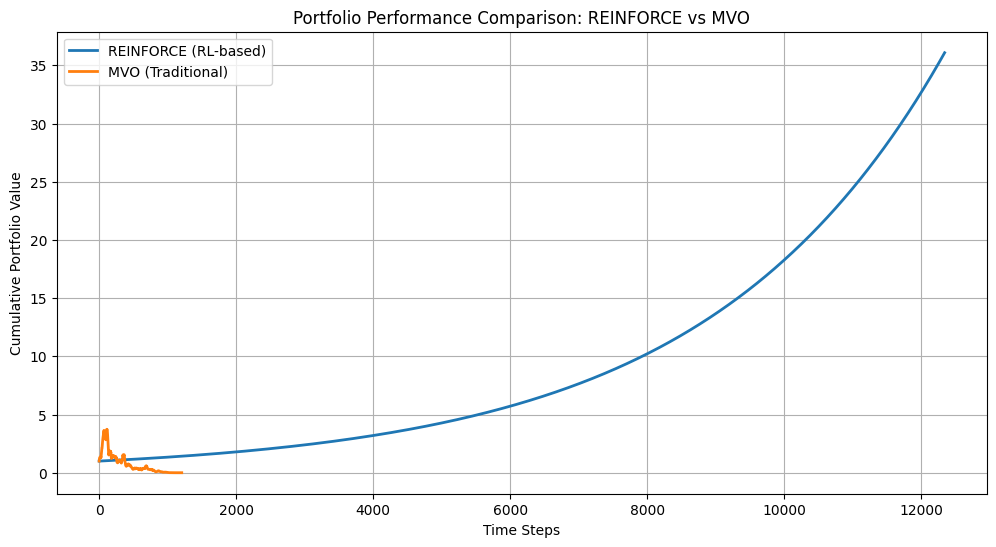

In [ ]:
import matplotlib.pyplot as plt

# Plot cumulative returns for REINFORCE and MVO
plt.figure(figsize=(12, 6))
plt.plot(cumulative_rl, label='REINFORCE (RL-based)', linewidth=2)
plt.plot(cumulative_mvo, label='MVO (Traditional)', linewidth=2)
plt.title('Portfolio Performance Comparison: REINFORCE vs MVO')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Portfolio Value')
plt.legend()
plt.grid()
plt.show()


Sharpe Ratio (REINFORCE): 127.7474, Max Drawdown (REINFORCE): 0.0000%
Sharpe Ratio (MVO): -0.2640, Max Drawdown (MVO): -99.9987%


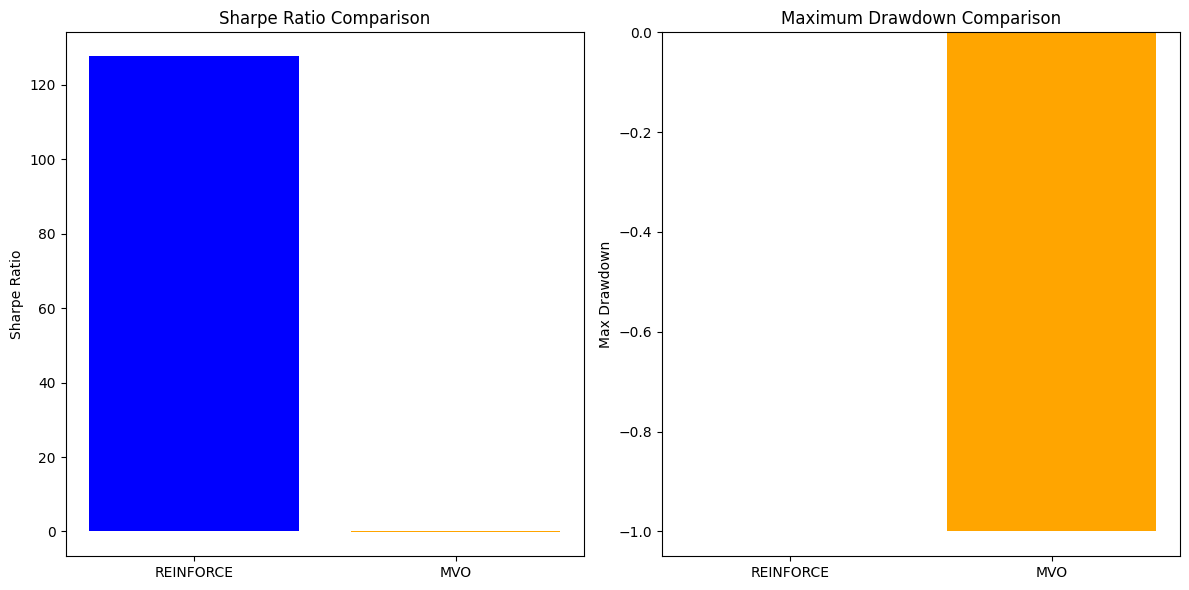

In [ ]:
# Print results
print(f"Sharpe Ratio (REINFORCE): {sharpe_reinforce:.4f}, Max Drawdown (REINFORCE): {mdd_reinforce:.4%}")
print(f"Sharpe Ratio (MVO): {sharpe_mvo:.4f}, Max Drawdown (MVO): {mdd_mvo:.4%}")

# Plotting the Sharpe Ratio and Maximum Drawdown
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot Sharpe Ratio
ax[0].bar(['REINFORCE', 'MVO'], [sharpe_reinforce, sharpe_mvo], color=['blue', 'orange'])
ax[0].set_title('Sharpe Ratio Comparison')
ax[0].set_ylabel('Sharpe Ratio')

# Plot Maximum Drawdown
ax[1].bar(['REINFORCE', 'MVO'], [mdd_reinforce, mdd_mvo], color=['blue', 'orange'])
ax[1].set_title('Maximum Drawdown Comparison')
ax[1].set_ylabel('Max Drawdown')

plt.tight_layout()
plt.show()


# Citations

https://icaps23.icaps-conference.org/papers/finplan/FinPlan23_paper_4.pdf

https://www.aimspress.com/article/id/66d6e6b1ba35de7444b3ce97

https://arxiv.org/pdf/1904.04973
